# 숙제1:  폐렴검출 전이학습


The code below is copied from
 https://www.kaggle.com/kashyapgohil/pneumonia-detection-using-cnn

 The Author of the code is Kashyap Gohil

 영상 데이터셋은 다음 링크에서 얻을 수 있다: 
 https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia 

데이터셋에 대한 설명:
데이터 세트는 3개의 폴더(train, test, validation)로 구성되며 각각에 대하여 클래스 (폐렴/정상)에 대한 하위 폴더를 포함하고 있다. 본 데이터세트는 5,863개의 X선 영상(JPEG)으로 이루어졌고,광저우시 광저우 여성아동병원에서 1~5세 소아환자를 대상으로 촬영한 흉부 X선 영상이다. 저품질 또는 판독이 불가능한 영상은 제외가 되었고, 두 명의 전문의에 의해 이미지에 대한 진단 점수가 매겨졌다. 

In [1]:
# 필요한 모듈 import하기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import tensorflow as tf

In [2]:
# 파일로부터 영상을 읽어서 data에 저장하기
labels = ['PNEUMONIA', 'NORMAL']
img_size = 299
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2BGR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_training_data('./chest_xray/train')
test = get_training_data('./chest_xray/test')
val = get_training_data('./chest_xray/val')

C:\Users\gka06\AppData\Local\Temp\ipykernel_25828\1138087934.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [4]:
print(train[2][1])

0


In [6]:
for feature, label in train[:3]:
  print(feature)
  print(label)

[[[19 19 19]
  [19 19 19]
  [24 24 24]
  ...
  [ 5  5  5]
  [ 2  2  2]
  [ 0  0  0]]

 [[19 19 19]
  [21 21 21]
  [24 24 24]
  ...
  [ 6  6  6]
  [ 3  3  3]
  [ 0  0  0]]

 [[18 18 18]
  [22 22 22]
  [24 24 24]
  ...
  [ 7  7  7]
  [ 5  5  5]
  [ 0  0  0]]

 ...

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  ...
  [15 15 15]
  [15 15 15]
  [15 15 15]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  ...
  [15 15 15]
  [15 15 15]
  [15 15 15]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  ...
  [15 15 15]
  [15 15 15]
  [15 15 15]]]
0
[[[62 62 62]
  [63 63 63]
  [68 68 68]
  ...
  [24 24 24]
  [23 23 23]
  [23 23 23]]

 [[64 64 64]
  [69 69 69]
  [76 76 76]
  ...
  [26 26 26]
  [23 23 23]
  [22 22 22]]

 [[69 69 69]
  [71 71 71]
  [77 77 77]
  ...
  [24 24 24]
  [24 24 24]
  [22 22 22]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
 

c:\Users\gka06\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

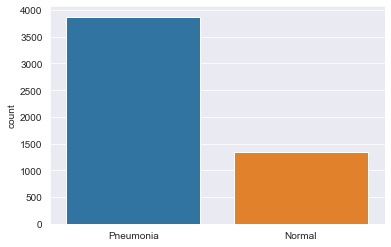

In [7]:
#폐렴과 정상 데이터의 갯수 확인하기
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

Text(0.5, 1.0, 'NORMAL')

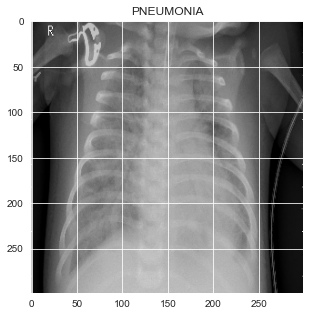

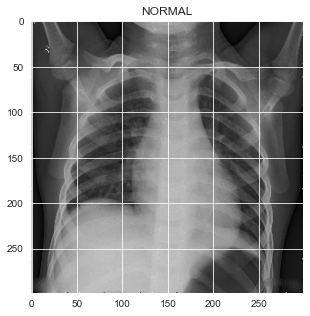

In [10]:
#영상으로 보이기
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [8]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [9]:
# 데이터를 Normalize 0~255     0~1
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [10]:
# 딥러닝을 위해 data를 resize
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [13]:
# data augmentation하기 (overfitting을 막고, 데이터셋내의 데이터 불균형도 어느 정도 해소)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [14]:
# =================================================== #
#  Pretrained Keras Model (2) --전체 미세조정         #
# =================================================== #

from keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(weights='imagenet',input_shape=(299,299,3) , include_top=True)

for layer in inception.layers[:]:
  layer.trainable = True
# for input you can also do model.input,
# then for base_outputs you can obviously
# choose other than simply removing the last one :)

base_inputs = inception.layers[0].input
base_outputs = inception.layers[-2].output
classifier = tf.keras.layers.Dense(2)(base_outputs)
new_model = keras.Model(inputs=base_inputs, outputs=classifier)

new_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

print(new_model.summary())

96124928/96112376 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [15]:
#learning_rate를 줄이는 방법. 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 20, verbose=1,factor=0.3, min_lr=0.000001)

In [16]:
history =new_model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 20 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/20
24/24 [==============================] - 42s 886ms/step - loss: 0.2948 - accuracy: 0.8838 - val_loss: 8.1710 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
24/24 [==============================] - 17s 686ms/step - loss: 0.1303 - accuracy: 0.9608 - val_loss: 12.4519 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
24/24 [==============================] - 17s 692ms/step - loss: 0.1764 - accuracy: 0.9216 - val_loss: 5.0554 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
24/24 [==============================] - 17s 690ms/step - loss: 0.1901 - accuracy: 0.9338 - val_loss: 6.3700 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/20
24/24 [==============================] - 17s 690ms/step - loss: 0.1485 - accuracy: 0.9446 - val_loss: 3.1255 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 6/20
24/24 [==============================] - 17s 685ms/step - loss: 0.1300 - accuracy: 0.9622 - val_loss: 13.2593 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 7/20
24/24 [==============================] - 17s 688ms/

In [ ]:
#learning_rate를 줄이는 방법. 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
print("Loss of the model is - " , new_model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , new_model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 8s 300ms/step - loss: 0.7467 - accuracy: 0.7035
Loss of the model is -  0.7466644644737244
20/20 [==============================] - 6s 301ms/step - loss: 0.7467 - accuracy: 0.7035
Accuracy of the model is -  70.35256624221802 %


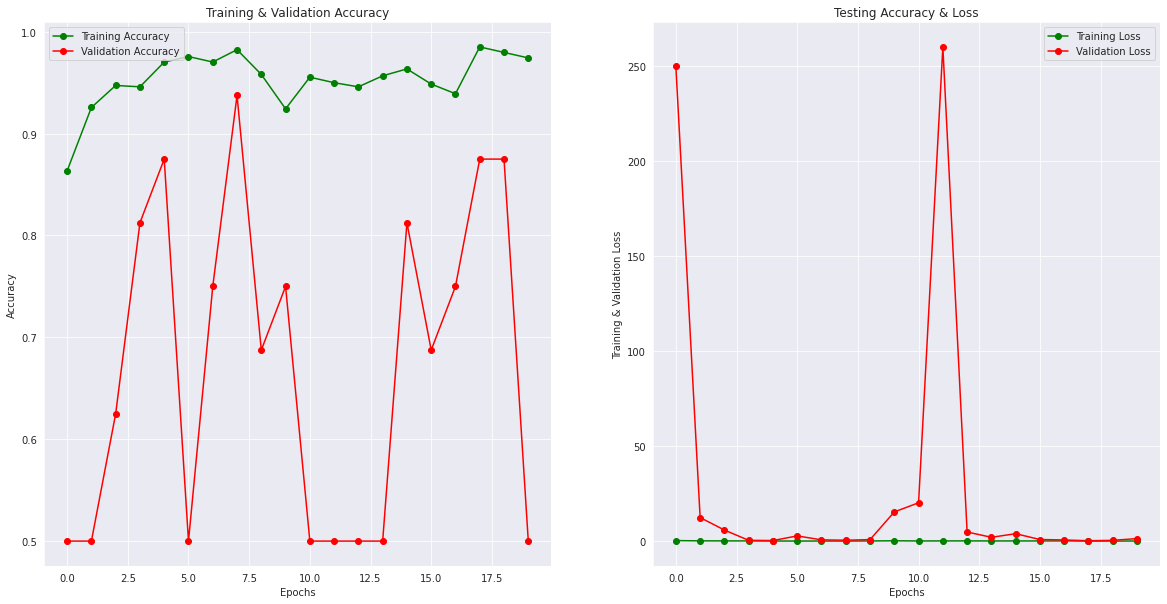

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()